In [264]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.ticker import PercentFormatter

In [265]:
vix = yf.download("^VIX", start="1990-01-01", end="2025-10-31")
vix.to_csv("vix_data.csv")

C:\Users\lukas\AppData\Local\Temp\ipykernel_7472\3424056596.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  vix = yf.download("^VIX", start="1990-01-01", end="2025-10-31")
[*********************100%***********************]  1 of 1 completed


In [266]:
# Wczytujemy dane, pomijając 3 pierwsze wiersze (nagłówki i "Date" w wierszu 2)
vix = pd.read_csv("vix_data.csv", skiprows=3, header=None)

# Nadajemy poprawne nazwy kolumn
vix.columns = ["Date", "Close", "High", "Low", "Open", "Volume"]

# Wybieramy tylko potrzebne kolumny
vix = vix[["Date", "Close"]].copy()

# 4️Konwersja dat i posortowanie
vix["Date"] = pd.to_datetime(vix["Date"], errors="coerce")
vix = vix.dropna(subset=["Date"])
vix = vix.sort_values("Date").reset_index(drop=True)

# Zapisujemy oczyszczony plik
vix.to_csv("vix_clean.csv", index=False)

In [267]:
vix.head()

,Date,Close
0,1990-01-02,17.240000
1,1990-01-03,18.190001
2,1990-01-04,19.219999
3,1990-01-05,20.110001
4,1990-01-08,20.260000


In [268]:
# Wczytujemy dane S&P 500
sp500 = pd.read_csv("sap500.csv")

# Upewniamy się, że kolumna z datą jest w formacie datetime
sp500['Date'] = pd.to_datetime(sp500['Date'], errors='coerce')

# Usuwamy wiersze z brakującą datą
sp500 = sp500.dropna(subset=['Date'])

# Filtrujemy okres 1990-01-01 – 2025-10-30
mask = (sp500['Date'] >= "1990-01-01") & (sp500['Date'] <= "2025-10-30")
sp500 = sp500.loc[mask]

# Zostawiamy tylko kolumny Date i Close
sp500 = sp500[['Date', 'Close']].copy()

# Sortujemy dane chronologicznie
sp500 = sp500.sort_values('Date').reset_index(drop=True)

# Zapisujemy oczyszczony plik
sp500.to_csv("sp500_clean.csv", index=False)

In [269]:
sp500.head()

,Date,Close
0,1990-01-02,359.690002
1,1990-01-03,358.760010
2,1990-01-04,355.670013
3,1990-01-05,352.200012
4,1990-01-08,353.790009


In [270]:
# Zmieniamy nazwę kolumny Close w VIX, żeby nie kolidowała
vix = vix.rename(columns={'Close': 'VIX_Close'})

# Łączymy tabele po kolumnie 'Date' (left join: wszystkie daty S&P 500)
df = pd.merge(sp500, vix, on='Date', how='left')

In [271]:
df.head()

,Date,Close,VIX_Close
0,1990-01-02,359.690002,17.240000
1,1990-01-03,358.760010,18.190001
2,1990-01-04,355.670013,19.219999
3,1990-01-05,352.200012,20.110001
4,1990-01-08,353.790009,20.260000


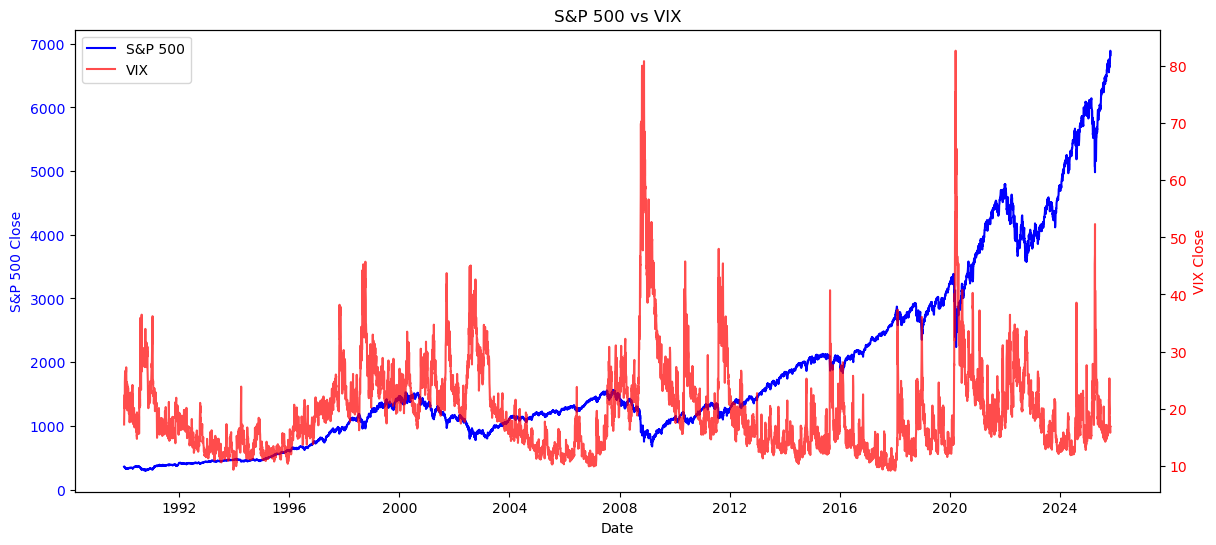

In [272]:
plt.figure(figsize=(14,6))

# Oś główna – S&P 500
ax1 = plt.gca()
ax1.plot(df['Date'], df['Close'], label='S&P 500', color='blue')
ax1.set_xlabel("Date")
ax1.set_ylabel("S&P 500 Close", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Druga oś – VIX
ax2 = ax1.twinx()
ax2.plot(df['Date'], df['VIX_Close'], label='VIX', color='red', alpha=0.7)
ax2.set_ylabel("VIX Close", color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Legendy – osobno dla obu osi
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.title("S&P 500 vs VIX")
plt.show()

In [273]:
# Wczytujemy pełne dane S&P 500
sp500_full = pd.read_csv("sap500.csv")
sp500_full['Date'] = pd.to_datetime(sp500_full['Date'], errors='coerce')
sp500_full = sp500_full.dropna(subset=['Date'])
sp500_full = sp500_full.sort_values('Date').reset_index(drop=True)

# Obliczamy 125-dniową średnią kroczącą na pełnym zbiorze
sp500_full['SMA_125'] = sp500_full['Close'].rolling(window=125).mean()

# Filtrujemy okres 1990-01-01 → 2025-10-30
mask = (sp500_full['Date'] >= "1990-01-01") & (sp500_full['Date'] <= "2025-10-30")
sp500_filtered = sp500_full.loc[mask, ['Date', 'SMA_125']].copy()

# Dołączamy SMA_125 do df (który już zawiera Close S&P i VIX)
df = pd.merge(df, sp500_filtered, on='Date', how='left')

In [274]:
df.head()

,Date,Close,VIX_Close,SMA_125
0,1990-01-02,359.690002,17.240000,344.28560
1,1990-01-03,358.760010,18.190001,344.58328
2,1990-01-04,355.670013,19.219999,344.82936
3,1990-01-05,352.200012,20.110001,345.03040
4,1990-01-08,353.790009,20.260000,345.23048


In [275]:
# Dołączamy kolumnę z dziennymi zmianami VIX
df['VIX_Change'] = df['VIX_Close'].diff()
df.head()

,Date,Close,VIX_Close,SMA_125,VIX_Change
0,1990-01-02,359.690002,17.240000,344.28560,NaN
1,1990-01-03,358.760010,18.190001,344.58328,0.950001
2,1990-01-04,355.670013,19.219999,344.82936,1.029999
3,1990-01-05,352.200012,20.110001,345.03040,0.890001
4,1990-01-08,353.790009,20.260000,345.23048,0.150000


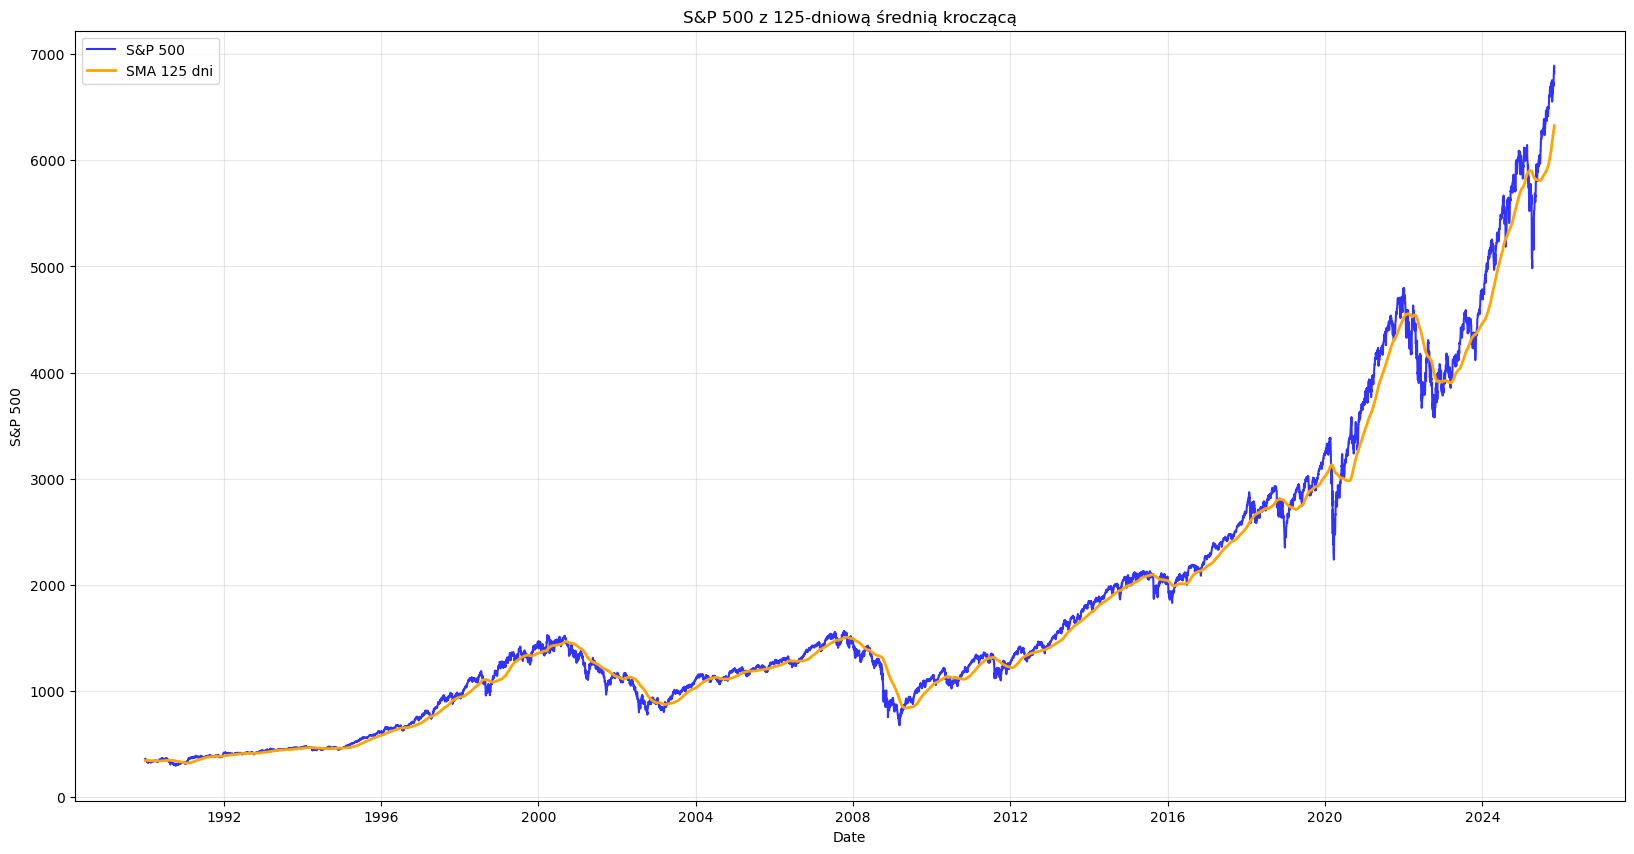

In [276]:
plt.figure(figsize=(20,10))

# Wykres Close S&P 500
plt.plot(df['Date'], df['Close'], label='S&P 500', color='blue', alpha=0.8)

# Wykres 125-dniowej średniej kroczącej
plt.plot(df['Date'], df['SMA_125'], label='SMA 125 dni', color='orange', linewidth=2)

# Tytuł i etykiety osi
plt.title("S&P 500 z 125-dniową średnią kroczącą")
plt.xlabel("Date")
plt.ylabel("S&P 500")

# Legenda
plt.legend(loc='upper left')

# Siatka
plt.grid(True, alpha=0.3)

plt.show()

In [277]:
# Odległość od SMA_125
df['Distance_from_SMA'] = df['Close'] - df['SMA_125']
df.head()

,Date,Close,VIX_Close,SMA_125,VIX_Change,Distance_from_SMA
0,1990-01-02,359.690002,17.240000,344.28560,NaN,15.404403
1,1990-01-03,358.760010,18.190001,344.58328,0.950001,14.176730
2,1990-01-04,355.670013,19.219999,344.82936,1.029999,10.840653
3,1990-01-05,352.200012,20.110001,345.03040,0.890001,7.169612
4,1990-01-08,353.790009,20.260000,345.23048,0.150000,8.559528


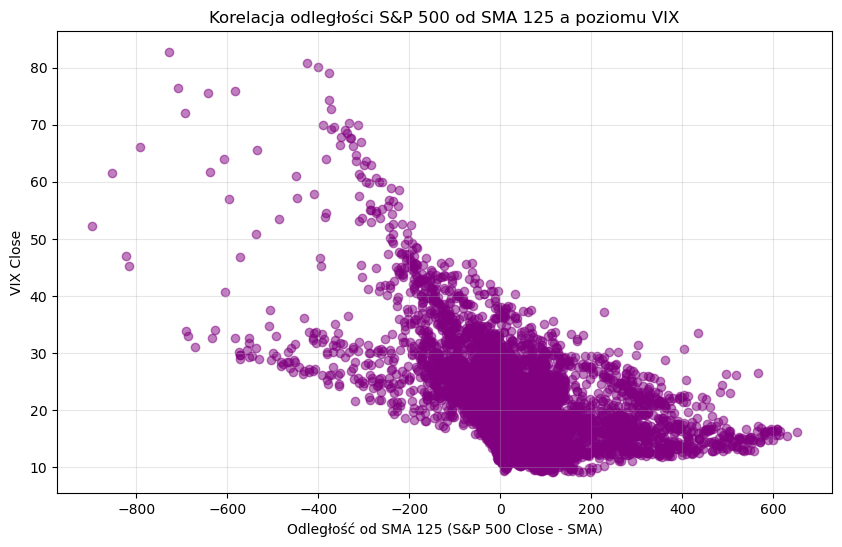

In [278]:
plt.figure(figsize=(10,6))

# Scatter plot: Distance_from_SMA vs VIX
plt.scatter(df['Distance_from_SMA'], df['VIX_Close'], alpha=0.5, color='purple')

plt.title("Korelacja odległości S&P 500 od SMA 125 a poziomu VIX")
plt.xlabel("Odległość od SMA 125 (S&P 500 Close - SMA)")
plt.ylabel("VIX Close")
plt.grid(True, alpha=0.3)
plt.show()

In [279]:
df['VIX_Close'].mean()

19.464452079181196

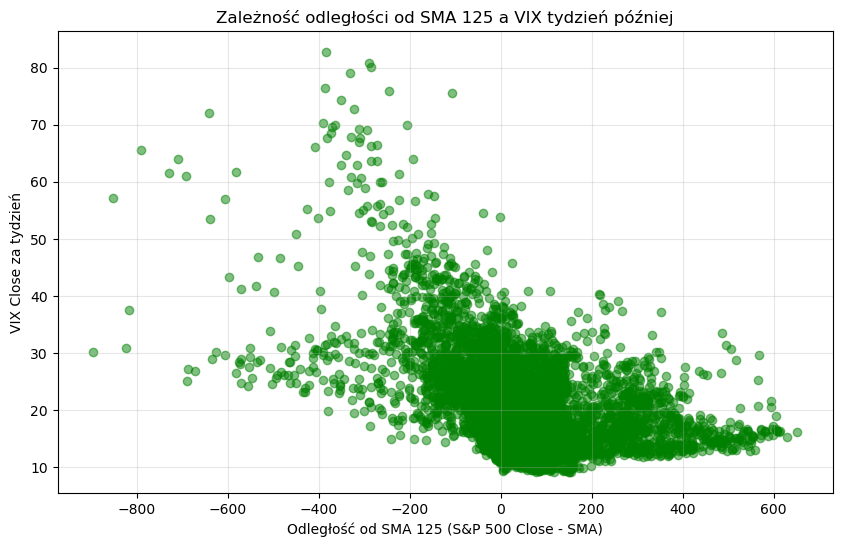

In [280]:
# Tworzymy kolumnę VIX_7_days_later (5 dni roboczych)
df['VIX_7_days_later'] = df['VIX_Close'].shift(-5)

# Usuwamy ostatnie 7 dni, które będą miały NaN
df_shifted = df.dropna(subset=['VIX_7_days_later'])

# Scatter plot: Distance_from_SMA vs VIX tydzień później
plt.figure(figsize=(10,6))
plt.scatter(df_shifted['Distance_from_SMA'], df_shifted['VIX_7_days_later'],
            alpha=0.5, color='green')
plt.title("Zależność odległości od SMA 125 a VIX tydzień później")
plt.xlabel("Odległość od SMA 125 (S&P 500 Close - SMA)")
plt.ylabel("VIX Close za tydzień")
plt.grid(True, alpha=0.3)
plt.show()

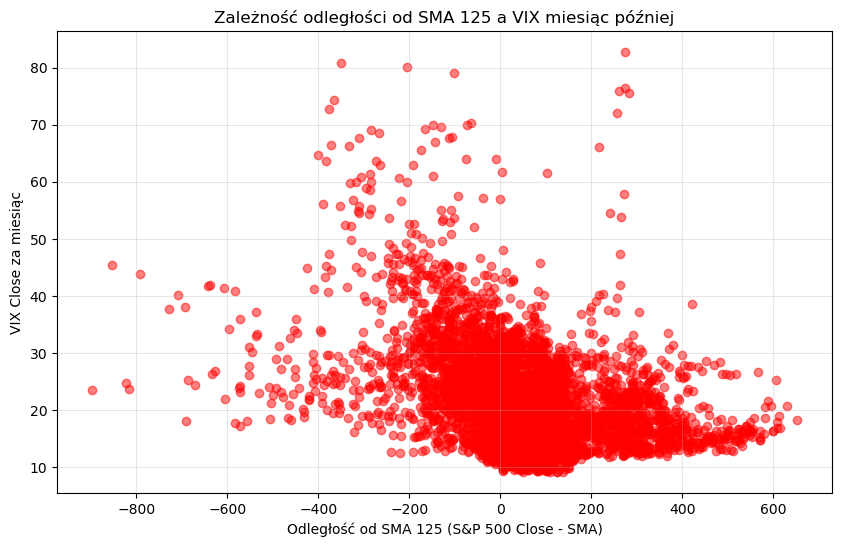

In [281]:
# Tworzymy kolumnę VIX_30_days_later (4 tygodnie tj. 20 dni roboczych)
df['VIX_30_days_later'] = df['VIX_Close'].shift(-20)

# Usuwamy ostatnie 4 tygodnie, które będą miały NaN
df_shifted_30 = df.dropna(subset=['VIX_30_days_later'])

# Scatter plot: Distance_from_SMA vs VIX miesiąc później
plt.figure(figsize=(10,6))
plt.scatter(df_shifted_30['Distance_from_SMA'], df_shifted_30['VIX_30_days_later'],
            alpha=0.5, color='red')
plt.title("Zależność odległości od SMA 125 a VIX miesiąc później")
plt.xlabel("Odległość od SMA 125 (S&P 500 Close - SMA)")
plt.ylabel("VIX Close za miesiąc")
plt.grid(True, alpha=0.3)
plt.show()

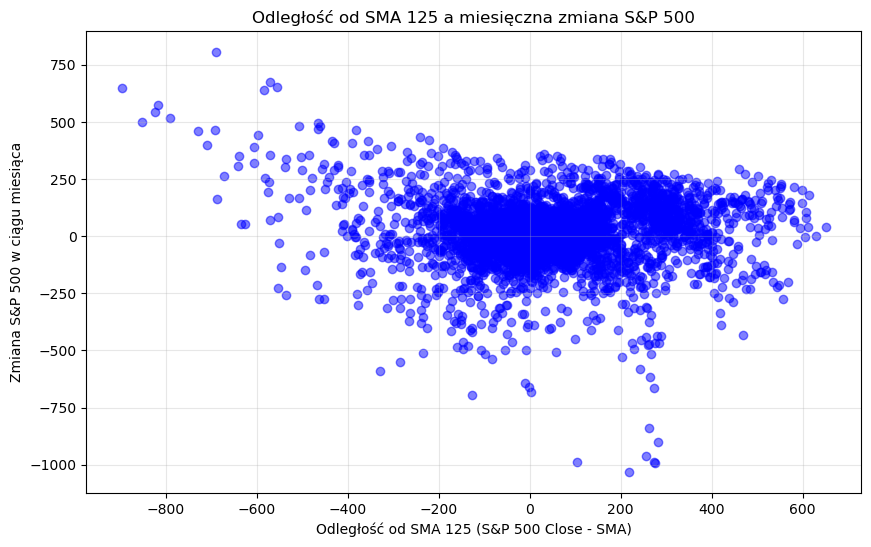

In [282]:
# Tworzymy kolumnę z miesięczną zmianą S&P 500
df['SP500_change_30d'] = df['Close'].shift(-20) - df['Close']

# Usuwamy ostatnie 20 dni, które będą miały NaN
df_shifted_sp500 = df.dropna(subset=['SP500_change_30d'])

# Scatter plot: Distance_from_SMA vs miesięczna zmiana S&P 500
plt.figure(figsize=(10,6))
plt.scatter(df_shifted_sp500['Distance_from_SMA'], df_shifted_sp500['SP500_change_30d'],
            alpha=0.5, color='blue')
plt.title("Odległość od SMA 125 a miesięczna zmiana S&P 500")
plt.xlabel("Odległość od SMA 125 (S&P 500 Close - SMA)")
plt.ylabel("Zmiana S&P 500 w ciągu miesiąca")
plt.grid(True, alpha=0.3)
plt.show()

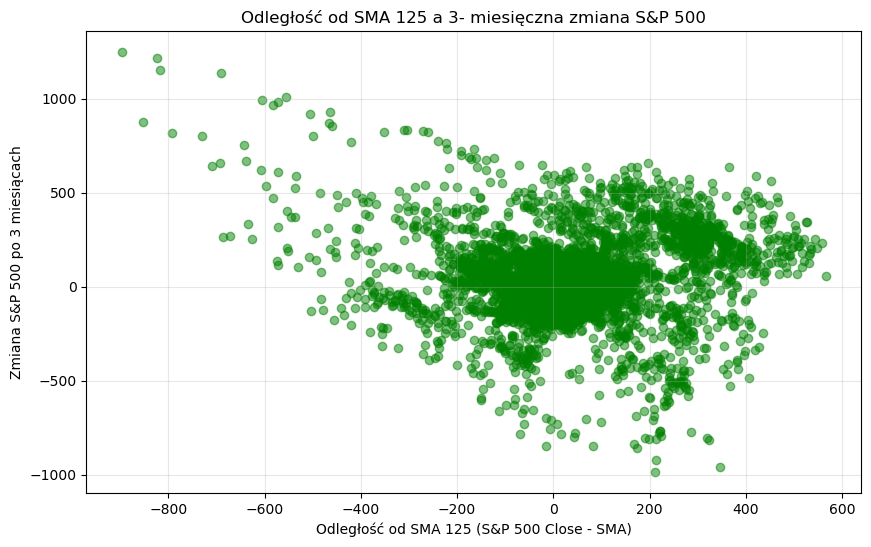

In [283]:
# Tworzymy kolumnę z 90-dniową zmianą S&P 500 (3x 4 tygodnie)
df['SP500_change_90d'] = df['Close'].shift(-60) - df['Close']

# Usuwamy ostatnie 3 miesiące, które będą miały NaN
df_shifted_sp500_90 = df.dropna(subset=['SP500_change_90d'])

# Scatter plot: Distance_from_SMA vs 3-miesięczna zmiana S&P 500
plt.figure(figsize=(10,6))
plt.scatter(df_shifted_sp500_90['Distance_from_SMA'], df_shifted_sp500_90['SP500_change_90d'],
            alpha=0.5, color='green')
plt.title("Odległość od SMA 125 a 3- miesięczna zmiana S&P 500")
plt.xlabel("Odległość od SMA 125 (S&P 500 Close - SMA)")
plt.ylabel("Zmiana S&P 500 po 3 miesiącach")
plt.grid(True, alpha=0.3)
plt.show()

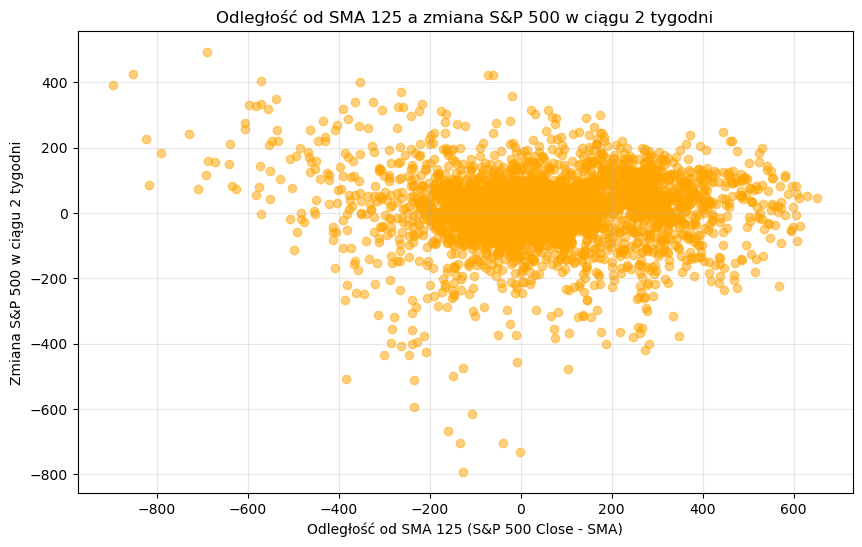

In [284]:
# Tworzymy kolumnę z dwutygodniową zmianą S&P 500
df['SP500_change_14d'] = df['Close'].shift(-10) - df['Close']

# Usuwamy ostatnie dni, które będą miały NaN
df_shifted_sp500_14 = df.dropna(subset=['SP500_change_14d'])

# Scatter plot: Distance_from_SMA vs zmiana S&P 500 w 14 dni
plt.figure(figsize=(10,6))
plt.scatter(df_shifted_sp500_14['Distance_from_SMA'], df_shifted_sp500_14['SP500_change_14d'],
            alpha=0.5, color='orange')
plt.title("Odległość od SMA 125 a zmiana S&P 500 w ciągu 2 tygodni")
plt.xlabel("Odległość od SMA 125 (S&P 500 Close - SMA)")
plt.ylabel("Zmiana S&P 500 w ciągu 2 tygodni")
plt.grid(True, alpha=0.3)
plt.show()

In [285]:
# Usuwamy wiersze z brakującymi SP500_change_30d
df_shifted_sp500 = df.dropna(subset=['SP500_change_30d'])

# Filtrujemy tylko ujemne odległości od SMA
df_negative = df_shifted_sp500[df_shifted_sp500['Distance_from_SMA'] < 0]

# Sortujemy rosnąco po Distance_from_SMA
df_negative_sorted = df_negative.sort_values('Distance_from_SMA')

# Pobieramy wszystkie unikalne wartości ujemne w kolejności rosnącej
negative_values = np.sort(df_negative_sorted['Distance_from_SMA'].unique())

threshold = None

# Iterujemy od najmniej ujemnej wartości w stronę najbardziej ujemnej
for dist in reversed(negative_values):  # od największej ujemnej w kierunku -inf
    subset = df_negative_sorted[df_negative_sorted['Distance_from_SMA'] <= dist]
    if (subset['SP500_change_30d'] > 0).all():
        threshold = dist
        break

print(f"Największa ujemna wartość Distance_from_SMA, dla której wszystkie bardziej ujemne wartości dają dodatnią zmianę S&P 500 po 30 dniach: {threshold:.2f}")

Największa ujemna wartość Distance_from_SMA, dla której wszystkie bardziej ujemne wartości dają dodatnią zmianę S&P 500 po 30 dniach: -556.46


In [286]:
# 200 największych odległości od SMA 125
top200_distance = df.sort_values(by='Distance_from_SMA', ascending=False).head(200)

print("200 największych odczytów Distance_from_SMA:")
print(top200_distance[['Date', 'Close', 'Distance_from_SMA', 'SP500_change_90d']])

200 największych odczytów Distance_from_SMA:
           Date        Close  Distance_from_SMA  SP500_change_90d
8996 2025-09-22  6693.750000         651.790016               NaN
8995 2025-09-19  6664.359863         629.809320               NaN
9003 2025-10-01  6711.200195         613.838687               NaN
8991 2025-09-15  6615.279785         611.793477               NaN
8997 2025-09-23  6656.919922         607.917777               NaN
9004 2025-10-02  6715.350098         607.437949               NaN
9006 2025-10-06  6740.279785         605.809719               NaN
8994 2025-09-18  6631.959961         605.383816               NaN
9002 2025-09-30  6688.459961         599.420293               NaN
8989 2025-09-11  6587.470215         599.067984               NaN
8992 2025-09-16  6606.759766         595.336660               NaN
9008 2025-10-08  6753.720215         595.021027               NaN
9005 2025-10-03  6715.790039         594.744211               NaN
8990 2025-09-12  6584.290039   

In [287]:
# Filtrujemy obserwacje, w których Distance_from_SMA >= 570
df_positive_high = df_shifted_sp500[df_shifted_sp500['Distance_from_SMA'] >= 570]

# Maksymalny spadek po 30 dniach (najmniejsza wartość SP500_change_30d)
max_drop_30d = df_positive_high['SP500_change_30d'].min()

print(f"Maksymalny spadek S&P 500 po 30 dniach dla Distance_from_SMA >= 570: {max_drop_30d:.2f}")

Maksymalny spadek S&P 500 po 30 dniach dla Distance_from_SMA >= 570: -31.78


In [288]:
df.head()

,Date,Close,VIX_Close,SMA_125,VIX_Change,Distance_from_SMA,VIX_7_days_later,VIX_30_days_later,SP500_change_30d,SP500_change_90d,SP500_change_14d
0,1990-01-02,359.690002,17.240000,344.28560,NaN,15.404403,22.200001,27.250000,-36.709991,-17.690002,-18.940002
1,1990-01-03,358.760010,18.190001,344.58328,0.950001,14.176730,22.440001,25.360001,-29.680023,-17.970001,-21.360016
2,1990-01-04,355.670013,19.219999,344.82936,1.029999,10.840653,20.049999,24.870001,-26.880005,-15.730011,-17.480011
3,1990-01-05,352.200012,20.110001,345.03040,0.890001,7.169612,24.639999,24.320000,-21.279999,-13.500000,-13.050018
4,1990-01-08,353.790009,20.260000,345.23048,0.150000,8.559528,26.340000,24.540001,-21.940002,-10.149994,-23.410004


In [289]:
# Usuwamy wiersze z brakującymi wartościami SP500_change_14d
df_bins_14d = df.dropna(subset=['SP500_change_14d'])

# Definiujemy uproszczone koszyki dla Distance_from_SMA
bins = [-np.inf, -400, -200, 0, 200, 400, np.inf]
labels = ["< -400", "-400 to -200", "-200 to 0", "0 to 200", "200 to 400", "> 400"]

# Przypisujemy każdy wiersz do odpowiedniego koszyka
df_bins_14d['Distance_bin'] = pd.cut(df_bins_14d['Distance_from_SMA'], bins=bins, labels=labels, include_lowest=True)

# Liczymy przypadki wzrostu (>0) i spadku (<=0) dla każdego koszyka
summary_table_14d = df_bins_14d.groupby('Distance_bin')['SP500_change_14d'].agg(
    Up=lambda x: (x > 0).sum(),
    Down=lambda x: (x <= 0).sum()
)

# Wyświetlamy tabelę
print("Zmiana S&P 500 w ciągu 14 dni względem odległości od SMA 125:")
print(summary_table_14d)

Zmiana S&P 500 w ciągu 14 dni względem odległości od SMA 125:
                Up  Down
Distance_bin            
< -400          59    13
-400 to -200   117    89
-200 to 0     1317   885
0 to 200      3450  2298
200 to 400     407   220
> 400          103    57


C:\Users\lukas\AppData\Local\Temp\ipykernel_7472\973705194.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bins_14d['Distance_bin'] = pd.cut(df_bins_14d['Distance_from_SMA'], bins=bins, labels=labels, include_lowest=True)
C:\Users\lukas\AppData\Local\Temp\ipykernel_7472\973705194.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_table_14d = df_bins_14d.groupby('Distance_bin')['SP500_change_14d'].agg(


In [290]:
# Usuwamy wiersze z brakującymi wartościami SP500_change_30d
df_bins = df.dropna(subset=['SP500_change_30d'])

# Definiujemy uproszczone koszyki
bins = [-np.inf, -400, -200, 0, 200, 400, np.inf]
labels = ["< -400", "-400 to -200", "-200 to 0", "0 to 200", "200 to 400", "> 400"]

# Przypisujemy każdy wiersz do odpowiedniego koszyka
df_bins['Distance_bin'] = pd.cut(df_bins['Distance_from_SMA'], bins=bins, labels=labels, include_lowest=True)

# Zliczamy przypadki wzrostu (>0) i spadku (<=0) dla każdego koszyka
summary_table = df_bins.groupby('Distance_bin')['SP500_change_30d'].agg(
    Up=lambda x: (x > 0).sum(),
    Down=lambda x: (x <= 0).sum()
)

# Wyświetlamy tabelę
print(summary_table)

                Up  Down
Distance_bin            
< -400          62    10
-400 to -200   114    92
-200 to 0     1352   850
0 to 200      3658  2090
200 to 400     448   178
> 400           98    53


C:\Users\lukas\AppData\Local\Temp\ipykernel_7472\1573891333.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bins['Distance_bin'] = pd.cut(df_bins['Distance_from_SMA'], bins=bins, labels=labels, include_lowest=True)
C:\Users\lukas\AppData\Local\Temp\ipykernel_7472\1573891333.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_table = df_bins.groupby('Distance_bin')['SP500_change_30d'].agg(


In [291]:
# Usuwamy wiersze z brakującymi wartościami SP500_change_90d
df_bins_90d = df.dropna(subset=['SP500_change_90d'])

# Definiujemy koszyki (te same co wcześniej)
bins = [-np.inf, -400, -200, 0, 200, 400, np.inf]
labels = ["< -400", "-400 to -200", "-200 to 0", "0 to 200", "200 to 400", "> 400"]

# Przypisujemy każdy wiersz do odpowiedniego koszyka na podstawie Distance_from_SMA
df_bins_90d['Distance_bin'] = pd.cut(df_bins_90d['Distance_from_SMA'], bins=bins, labels=labels, include_lowest=True)

# Zliczamy przypadki wzrostu (>0) i spadku (<=0) w ciągu 90 dni dla każdego koszyka
summary_table_90d = df_bins_90d.groupby('Distance_bin')['SP500_change_90d'].agg(
    Up=lambda x: (x > 0).sum(),
    Down=lambda x: (x <= 0).sum()
)

# Wyświetlamy tabelę
print("📊 Zmiana S&P 500 w ciągu 90 dni względem odległości od SMA 125:")
print(summary_table_90d)

📊 Zmiana S&P 500 w ciągu 90 dni względem odległości od SMA 125:
                Up  Down
Distance_bin            
< -400          60    12
-400 to -200   107    99
-200 to 0     1463   739
0 to 200      4095  1653
200 to 400     446   180
> 400          102     9


C:\Users\lukas\AppData\Local\Temp\ipykernel_7472\2439345425.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bins_90d['Distance_bin'] = pd.cut(df_bins_90d['Distance_from_SMA'], bins=bins, labels=labels, include_lowest=True)
C:\Users\lukas\AppData\Local\Temp\ipykernel_7472\2439345425.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_table_90d = df_bins_90d.groupby('Distance_bin')['SP500_change_90d'].agg(


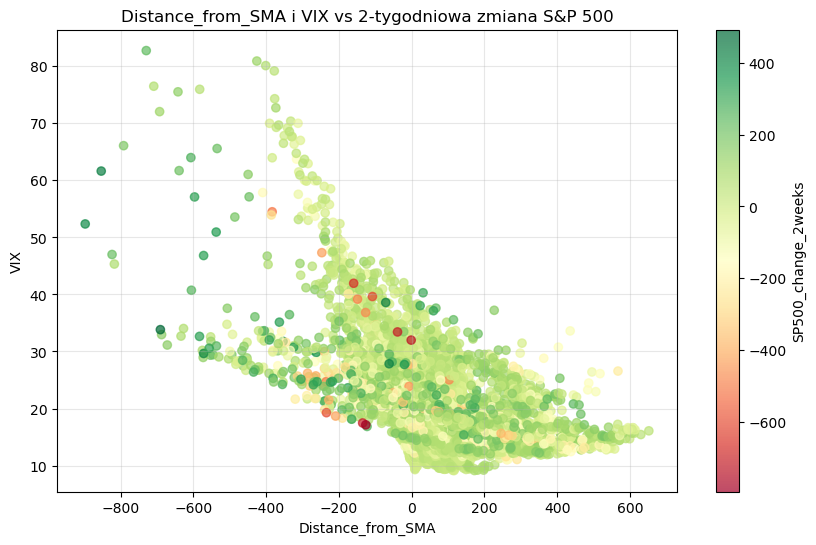

In [292]:
# Usuwamy brakujące wartości
df_plot_14d = df.dropna(subset=['SP500_change_14d', 'VIX_Close'])

# Wykres punktowy
plt.figure(figsize=(10,6))
scatter = plt.scatter(
    df_plot_14d['Distance_from_SMA'],
    df_plot_14d['VIX_Close'],
    c=df_plot_14d['SP500_change_14d'],  # kolor wg zmiany S&P 500 w 14 dni
    cmap='RdYlGn',                      # zielony = wzrost, czerwony = spadek
    alpha=0.7
)

# Pasek kolorów
plt.colorbar(scatter, label='SP500_change_2weeks')

# Opisy osi i tytuł
plt.xlabel("Distance_from_SMA")
plt.ylabel("VIX")
plt.title("Distance_from_SMA i VIX vs 2-tygodniowa zmiana S&P 500")

plt.grid(True, alpha=0.3)
plt.show()

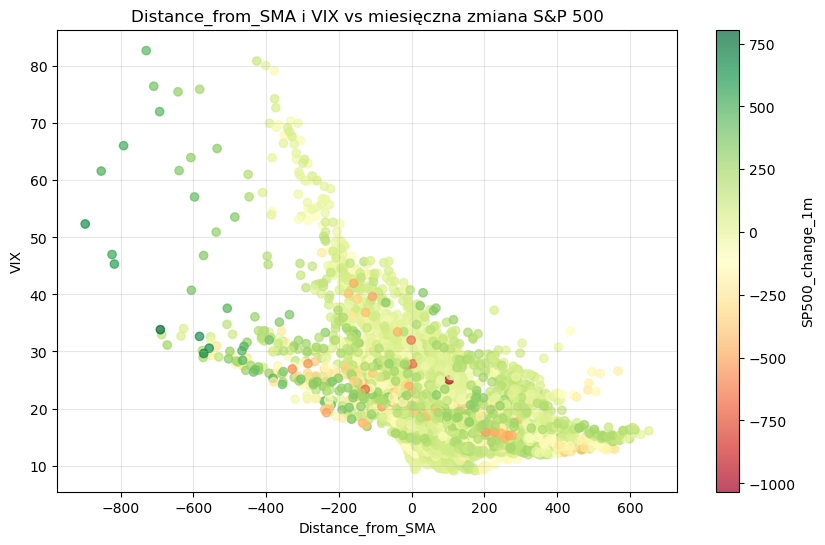

In [293]:
# Usuwamy brakujące wartości
df_plot = df.dropna(subset=['SP500_change_30d', 'VIX_Close'])

plt.figure(figsize=(10,6))
scatter = plt.scatter(
    df_plot['Distance_from_SMA'],
    df_plot['VIX_Close'],
    c=df_plot['SP500_change_30d'],  # kolor wg zmiany S&P 500
    cmap='RdYlGn',                  # zielony = wzrost, czerwony = spadek
    alpha=0.7
)
plt.colorbar(scatter, label='SP500_change_1m')
plt.xlabel("Distance_from_SMA")
plt.ylabel("VIX")
plt.title("Distance_from_SMA i VIX vs miesięczna zmiana S&P 500")
plt.grid(True, alpha=0.3)
plt.show()

C:\Users\lukas\AppData\Local\Temp\ipykernel_7472\3396975823.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['Distance_bin'] = pd.cut(df_plot['Distance_from_SMA'], bins=20)
C:\Users\lukas\AppData\Local\Temp\ipykernel_7472\3396975823.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['VIX_bin'] = pd.cut(df_plot['VIX_Close'], bins=20)
C:\Users\lukas\AppData\Local\Temp\ipykernel_7472\3396975823.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a

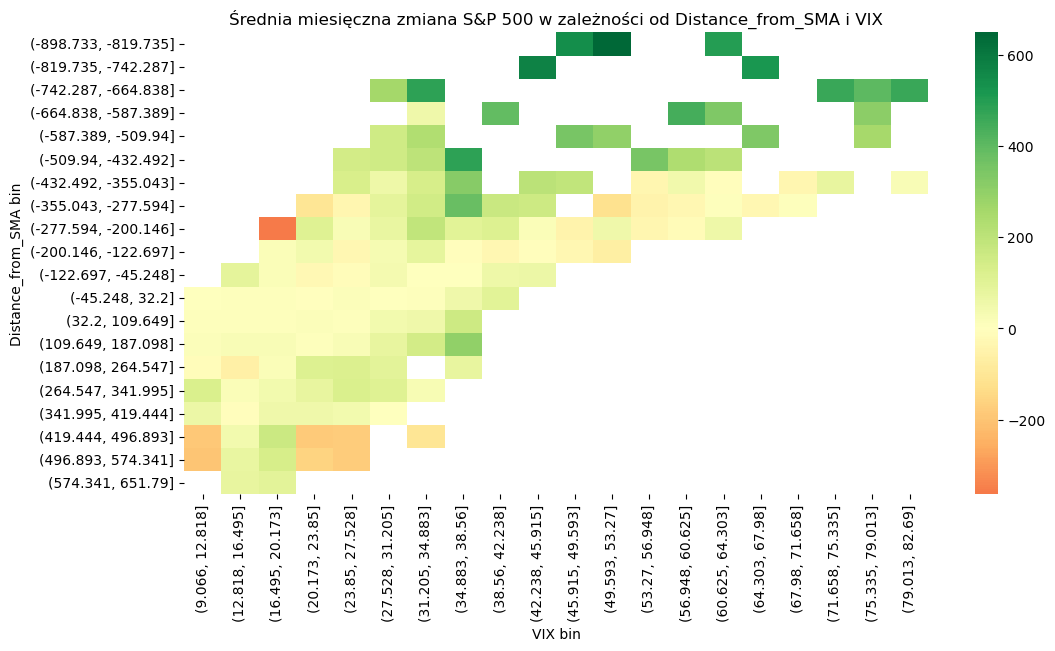

In [294]:
# Tworzymy koszyki
df_plot['Distance_bin'] = pd.cut(df_plot['Distance_from_SMA'], bins=20)
df_plot['VIX_bin'] = pd.cut(df_plot['VIX_Close'], bins=20)

# Grupujemy i liczymy średnią zmianę S&P500
heatmap_data = df_plot.groupby(['Distance_bin','VIX_bin'])['SP500_change_30d'].mean().unstack()

# Rysujemy heatmapę
plt.figure(figsize=(12,6))
sns.heatmap(heatmap_data, cmap='RdYlGn', center=0)
plt.title("Średnia miesięczna zmiana S&P 500 w zależności od Distance_from_SMA i VIX")
plt.xlabel("VIX bin")
plt.ylabel("Distance_from_SMA bin")
plt.show()

C:\Users\lukas\AppData\Local\Temp\ipykernel_7472\3571883237.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot_14d['Distance_bin'] = pd.cut(df_plot_14d['Distance_from_SMA'], bins=20)
C:\Users\lukas\AppData\Local\Temp\ipykernel_7472\3571883237.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot_14d['VIX_bin'] = pd.cut(df_plot_14d['VIX_Close'], bins=20)
C:\Users\lukas\AppData\Local\Temp\ipykernel_7472\3571883237.py:9: FutureWarning: The default of observed=False is deprecated and will be chan

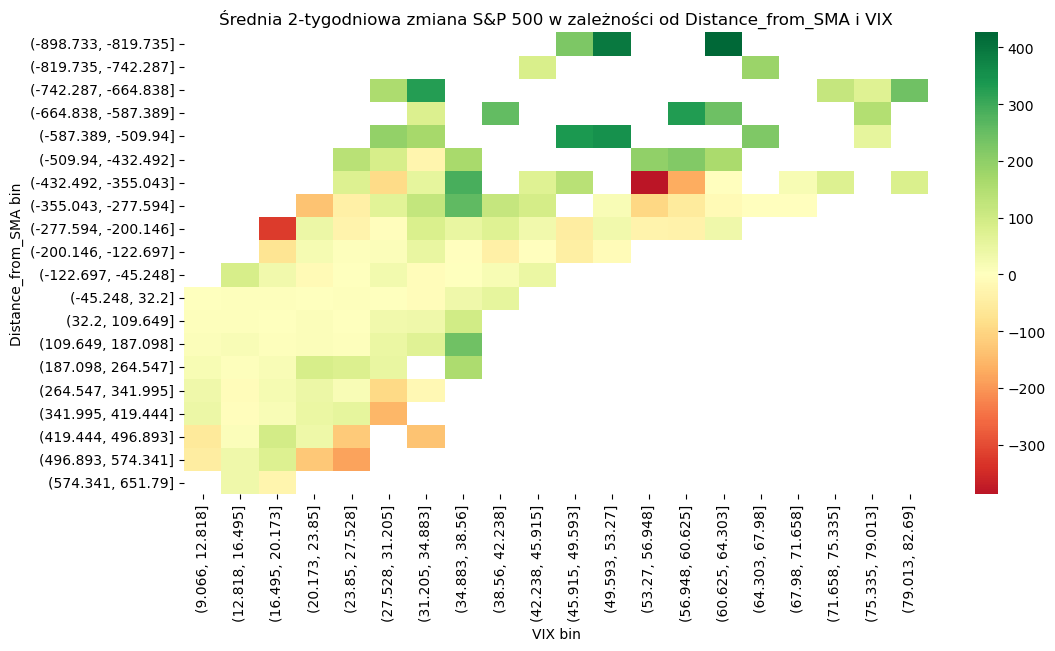

In [295]:
# Usuwamy brakujące wartości
df_plot_14d = df.dropna(subset=['SP500_change_14d', 'VIX_Close'])

# Tworzymy koszyki
df_plot_14d['Distance_bin'] = pd.cut(df_plot_14d['Distance_from_SMA'], bins=20)
df_plot_14d['VIX_bin'] = pd.cut(df_plot_14d['VIX_Close'], bins=20)

# Grupujemy i liczymy średnią zmianę S&P500 w 14 dni
heatmap_data_14d = df_plot_14d.groupby(['Distance_bin','VIX_bin'])['SP500_change_14d'].mean().unstack()

# Rysujemy heatmapę
plt.figure(figsize=(12,6))
sns.heatmap(heatmap_data_14d, cmap='RdYlGn', center=0)
plt.title("Średnia 2-tygodniowa zmiana S&P 500 w zależności od Distance_from_SMA i VIX")
plt.xlabel("VIX bin")
plt.ylabel("Distance_from_SMA bin")
plt.show()

In [296]:
# Filtrujemy przypadki, gdy VIX < 10 i mamy SP500_change_30d
vix_low = df.dropna(subset=['VIX_Close', 'SP500_change_30d'])
vix_low = vix_low[vix_low['VIX_Close'] < 10]

# Liczymy przypadki wzrostu i spadku S&P 500 po 30 dniach
up_count = (vix_low['SP500_change_30d'] > 0).sum()
down_count = (vix_low['SP500_change_30d'] < 0).sum()
total = len(vix_low)

print(f"Liczba przypadków gdy VIX < 10: {total}")
print(f"- S&P 500 wyżej po 30 dniach: {up_count} ({up_count/total*100:.2f}%)")
print(f"- S&P 500 niżej po 30 dniach: {down_count} ({down_count/total*100:.2f}%)")

Liczba przypadków gdy VIX < 10: 68
- S&P 500 wyżej po 30 dniach: 51 (75.00%)
- S&P 500 niżej po 30 dniach: 17 (25.00%)


In [297]:
# Filtrujemy przypadki, gdy VIX < 10 i mamy SP500_change_14d
vix_low_14d = df.dropna(subset=['VIX_Close', 'SP500_change_14d'])
vix_low_14d = vix_low_14d[vix_low_14d['VIX_Close'] < 10]

# Liczymy przypadki wzrostu i spadku S&P 500 po 14 dniach
up_count = (vix_low_14d['SP500_change_14d'] > 0).sum()
down_count = (vix_low_14d['SP500_change_14d'] < 0).sum()
total = len(vix_low_14d)

print(f"Liczba przypadków gdy VIX < 10: {total}")
print(f"- S&P 500 wyżej po 14 dniach: {up_count} ({up_count/total*100:.2f}%)")
print(f"- S&P 500 niżej po 14 dniach: {down_count} ({down_count/total*100:.2f}%)")

Liczba przypadków gdy VIX < 10: 68
- S&P 500 wyżej po 14 dniach: 56 (82.35%)
- S&P 500 niżej po 14 dniach: 12 (17.65%)


In [298]:
# Filtrujemy przypadki, gdy VIX < 10 i mamy SP500_change_14d
vix_low_14 = df.dropna(subset=['VIX_Close', 'SP500_change_14d'])
vix_low_14 = vix_low_14[vix_low_14['VIX_Close'] < 10]

# Maksymalny spadek po 14 dniach
max_drop_14 = vix_low_14['SP500_change_14d'].min()

print(f"Maksymalny spadek S&P 500 po 14 dniach przy VIX < 10: {max_drop_14:.2f} punktów")

Maksymalny spadek S&P 500 po 14 dniach przy VIX < 10: -52.54 punktów


In [299]:
# Filtrujemy przypadki, gdy VIX < 10 i mamy SP500_change_30d
vix_low = df.dropna(subset=['VIX_Close', 'SP500_change_30d'])
vix_low = vix_low[vix_low['VIX_Close'] < 10]

# Maksymalny spadek po 30 dniach
max_drop = vix_low['SP500_change_30d'].min()

print(f"Maksymalny spadek S&P 500 po 30 dniach przy VIX < 10: {max_drop:.2f} punktów")

Maksymalny spadek S&P 500 po 30 dniach przy VIX < 10: -167.23 punktów


In [300]:
# S&P 30 dni pozniej zaleznie od VIX
# Definiujemy progi VIX
vix_thresholds = [10, 15, 20, 25]

# Tworzymy listę wyników
results = []

for thresh in vix_thresholds:
    vix_low = df.dropna(subset=['VIX_Close', 'SP500_change_30d'])
    vix_low = vix_low[vix_low['VIX_Close'] < thresh]
    
    total = len(vix_low)
    up_count = (vix_low['SP500_change_30d'] > 0).sum()
    down_count = (vix_low['SP500_change_30d'] < 0).sum()
    max_drop = vix_low['SP500_change_30d'].min() if total > 0 else None
    
    results.append({
        'VIX_threshold': thresh,
        'Total_days': total,
        'Up_days': up_count,
        'Down_days': down_count,
        'Up_%': up_count/total*100 if total > 0 else None,
        'Down_%': down_count/total*100 if total > 0 else None,
        'Max_drop': max_drop
    })

# Tworzymy DataFrame z wynikami
results_df = pd.DataFrame(results)
print(results_df)

   VIX_threshold  Total_days  Up_days  Down_days       Up_%     Down_%  \
0             10          68       51         17  75.000000  25.000000   
1             15        2934     1926       1007  65.644172  34.321745   
2             20        5627     3626       2000  64.439310  35.542918   
3             25        7420     4687       2732  63.167116  36.819407   

      Max_drop  
0  -167.229980  
1  -994.030029  
2 -1032.830078  
3 -1032.830078  


In [301]:
# S&P 2 tygodnie pozniej zaleznie od VIX i przy distance from SMA > 400
# Definiujemy progi VIX
vix_thresholds = [10, 15, 20, 25]

# Tworzymy listę wyników
results_14d = []

for thresh in vix_thresholds:
    # Filtrujemy dane: Distance_from_SMA > 400 oraz VIX < próg
    df_filtered = df.dropna(subset=['VIX_Close', 'SP500_change_14d', 'Distance_from_SMA'])
    df_filtered = df_filtered[(df_filtered['Distance_from_SMA'] > 400) & (df_filtered['VIX_Close'] < thresh)]
    
    total = len(df_filtered)
    up_count = (df_filtered['SP500_change_14d'] > 0).sum()
    down_count = (df_filtered['SP500_change_14d'] < 0).sum()
    max_drop = df_filtered['SP500_change_14d'].min() if total > 0 else None
    
    results_14d.append({
        'VIX_threshold': thresh,
        'Total_days': total,
        'Up_days': up_count,
        'Down_days': down_count,
        'Up_%': up_count/total*100 if total > 0 else None,
        'Down_%': down_count/total*100 if total > 0 else None,
        'Max_drop': max_drop
    })

# Tworzymy DataFrame z wynikami
results_df_14d = pd.DataFrame(results_14d)
print(results_df_14d)

   VIX_threshold  Total_days  Up_days  Down_days       Up_%     Down_%  \
0             10           0        0          0        NaN        NaN   
1             15          76       47         29  61.842105  38.157895   
2             20         143       96         47  67.132867  32.867133   
3             25         154      102         52  66.233766  33.766234   

     Max_drop  
0         NaN  
1 -230.760254  
2 -237.109863  
3 -237.109863  


In [302]:
# S&P miesiac pozniej zaleznie od VIX i przy distance from SMA > 400
# Definiujemy progi VIX
vix_thresholds = [10, 15, 20, 25]

# Tworzymy listę wyników
results = []

for thresh in vix_thresholds:
    # Filtrujemy dane: Distance_from_SMA > 400 oraz VIX < próg
    df_filtered = df.dropna(subset=['VIX_Close', 'SP500_change_30d', 'Distance_from_SMA'])
    df_filtered = df_filtered[(df_filtered['Distance_from_SMA'] > 400) & (df_filtered['VIX_Close'] < thresh)]
    
    total = len(df_filtered)
    up_count = (df_filtered['SP500_change_30d'] > 0).sum()
    down_count = (df_filtered['SP500_change_30d'] < 0).sum()
    max_drop = df_filtered['SP500_change_30d'].min() if total > 0 else None
    
    results.append({
        'VIX_threshold': thresh,
        'Total_days': total,
        'Up_days': up_count,
        'Down_days': down_count,
        'Up_%': up_count/total*100 if total > 0 else None,
        'Down_%': down_count/total*100 if total > 0 else None,
        'Max_drop': max_drop
    })

# Tworzymy DataFrame z wynikami
results_df = pd.DataFrame(results)
print(results_df)

   VIX_threshold  Total_days  Up_days  Down_days       Up_%     Down_%  \
0             10           0        0          0        NaN        NaN   
1             15          76       43         33  56.578947  43.421053   
2             20         137       97         40  70.802920  29.197080   
3             25         146       98         48  67.123288  32.876712   

     Max_drop  
0         NaN  
1 -434.410156  
2 -434.410156  
3 -434.410156  


   VIX_threshold  Total_days       Up_%     Down_%    Max_drop
0             15          76  56.578947  43.421053 -434.410156
1             20         137  70.802920  29.197080 -434.410156


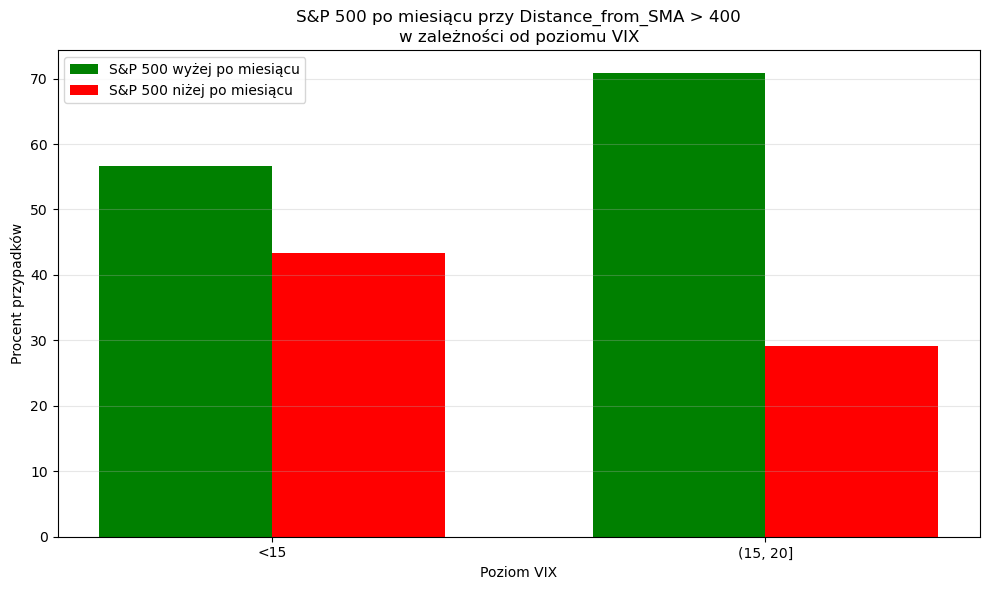

In [303]:
# Definiujemy progi VIX
vix_thresholds = [15, 20]
results = []

for thresh in vix_thresholds:
    df_filtered = df.dropna(subset=['VIX_Close', 'SP500_change_30d', 'Distance_from_SMA'])
    df_filtered = df_filtered[(df_filtered['Distance_from_SMA'] > 400) & (df_filtered['VIX_Close'] < thresh)]
    
    total = len(df_filtered)
    up_count = (df_filtered['SP500_change_30d'] > 0).sum()
    down_count = (df_filtered['SP500_change_30d'] < 0).sum()
    max_drop = df_filtered['SP500_change_30d'].min() if total > 0 else None
    
    results.append({
        'VIX_threshold': thresh,
        'Total_days': total,
        'Up_%': up_count/total*100 if total > 0 else 0,
        'Down_%': down_count/total*100 if total > 0 else 0,
        'Max_drop': max_drop
    })

results_df = pd.DataFrame(results)
print(results_df)

x_labels = ["<15", "(15, 20]"]  # pierwszy słupek: VIX < 15, drugi: 15 < VIX <= 20

plt.figure(figsize=(10,6))
bar_width = 0.35
x = range(len(results_df))

plt.bar(x, results_df['Up_%'], width=bar_width, color='green', label='S&P 500 wyżej po miesiącu')
plt.bar([p + bar_width for p in x], results_df['Down_%'], width=bar_width, color='red', label='S&P 500 niżej po miesiącu')

plt.xticks([p + bar_width/2 for p in x], x_labels)
plt.xlabel("Poziom VIX")
plt.ylabel("Procent przypadków")
plt.title("S&P 500 po miesiącu przy Distance_from_SMA > 400\nw zależności od poziomu VIX")
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

   VIX_threshold  Total_days       Up_%     Down_%    Max_drop
0             15          76  61.842105  38.157895 -230.760254
1             20         143  67.132867  32.867133 -237.109863


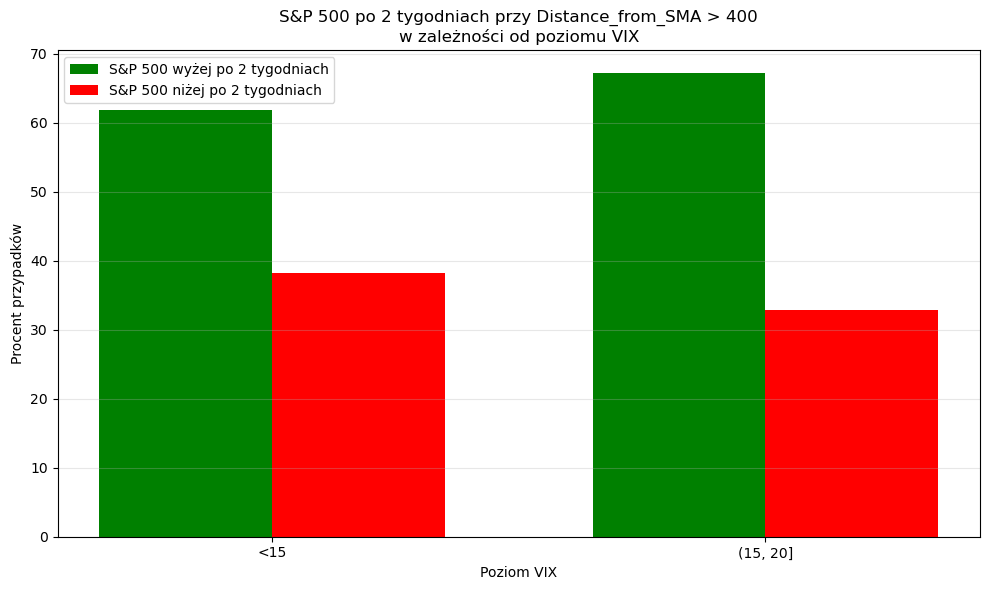

In [304]:
# Definiujemy progi VIX
vix_thresholds = [15, 20]
results_14d = []

for thresh in vix_thresholds:
    # Filtrujemy dane: Distance_from_SMA > 400 oraz VIX < próg
    df_filtered = df.dropna(subset=['VIX_Close', 'SP500_change_14d', 'Distance_from_SMA'])
    df_filtered = df_filtered[(df_filtered['Distance_from_SMA'] > 400) & (df_filtered['VIX_Close'] < thresh)]
    
    total = len(df_filtered)
    up_count = (df_filtered['SP500_change_14d'] > 0).sum()
    down_count = (df_filtered['SP500_change_14d'] < 0).sum()
    max_drop = df_filtered['SP500_change_14d'].min() if total > 0 else None
    
    results_14d.append({
        'VIX_threshold': thresh,
        'Total_days': total,
        'Up_%': up_count/total*100 if total > 0 else 0,
        'Down_%': down_count/total*100 if total > 0 else 0,
        'Max_drop': max_drop
    })

# Tworzymy DataFrame z wynikami
results_df_14d = pd.DataFrame(results_14d)
print(results_df_14d)

# Tworzymy etykiety przedziałów
x_labels = ["<15", "(15, 20]"] 

plt.figure(figsize=(10,6))
bar_width = 0.35
x = range(len(results_df_14d))

plt.bar(x, results_df_14d['Up_%'], width=bar_width, color='green', label='S&P 500 wyżej po 2 tygodniach')
plt.bar([p + bar_width for p in x], results_df_14d['Down_%'], width=bar_width, color='red', label='S&P 500 niżej po 2 tygodniach')

plt.xticks([p + bar_width/2 for p in x], x_labels)
plt.xlabel("Poziom VIX")
plt.ylabel("Procent przypadków")
plt.title("S&P 500 po 2 tygodniach przy Distance_from_SMA > 400\nw zależności od poziomu VIX")
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [305]:
df['VIX_change_30d'] = df['VIX_30_days_later'] - df['VIX_Close']

In [306]:
df['VIX_14_days_later'] = df['VIX_Close'].shift(-10)

In [307]:
df.head()

,Date,Close,VIX_Close,SMA_125,VIX_Change,Distance_from_SMA,VIX_7_days_later,VIX_30_days_later,SP500_change_30d,SP500_change_90d,SP500_change_14d,VIX_change_30d,VIX_14_days_later
0,1990-01-02,359.690002,17.240000,344.28560,NaN,15.404403,22.200001,27.250000,-36.709991,-17.690002,-18.940002,10.010000,24.180000
1,1990-01-03,358.760010,18.190001,344.58328,0.950001,14.176730,22.440001,25.360001,-29.680023,-17.970001,-21.360016,7.170000,24.160000
2,1990-01-04,355.670013,19.219999,344.82936,1.029999,10.840653,20.049999,24.870001,-26.880005,-15.730011,-17.480011,5.650002,24.340000
3,1990-01-05,352.200012,20.110001,345.03040,0.890001,7.169612,24.639999,24.320000,-21.279999,-13.500000,-13.050018,4.209999,22.500000
4,1990-01-08,353.790009,20.260000,345.23048,0.150000,8.559528,26.340000,24.540001,-21.940002,-10.149994,-23.410004,4.280001,26.700001


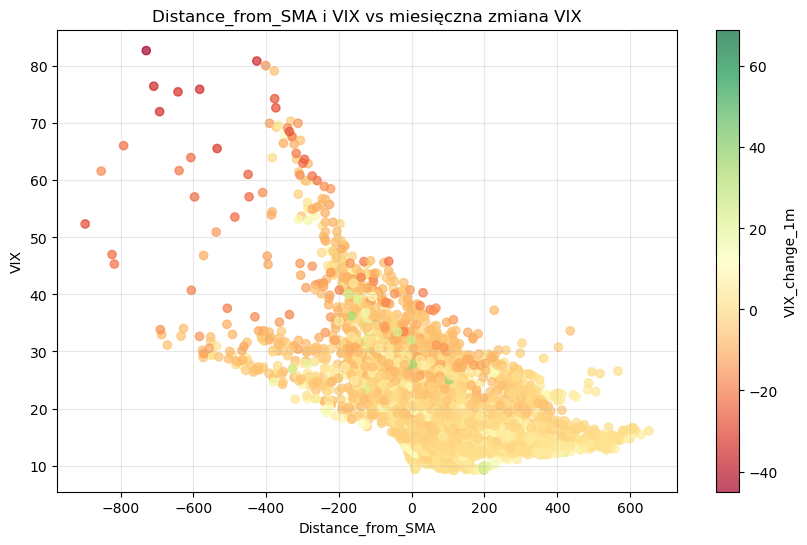

In [308]:
# Usuwamy brakujące wartości
df_plot = df.dropna(subset=['VIX_change_30d', 'VIX_Close'])

plt.figure(figsize=(10,6))
scatter = plt.scatter(
    df_plot['Distance_from_SMA'],
    df_plot['VIX_Close'],
    c=df_plot['VIX_change_30d'],  # kolor wg zmiany S&P 500
    cmap='RdYlGn',                  # zielony = wzrost, czerwony = spadek
    alpha=0.7
)
plt.colorbar(scatter, label='VIX_change_1m')
plt.xlabel("Distance_from_SMA")
plt.ylabel("VIX")
plt.title("Distance_from_SMA i VIX vs miesięczna zmiana VIX")
plt.grid(True, alpha=0.3)
plt.show()

In [309]:
# Definiujemy koszyki Distance_from_SMA
distance_bins = [-np.inf, -400, -200, 0, 200, 400, np.inf]
distance_labels = ["<= -400", "(-400, -200]", "(-200, 0]", "(0, 200]", "(200, 400]", "> 400"]

# Definiujemy koszyki VIX
vix_bins = [0, 10, 15, 20, 25, np.inf]
vix_labels = ["<10", "10–15", "15–20", "20–25", ">25"]

# Tworzymy kopię z potrzebnymi kolumnami
df_bins = df.dropna(subset=['VIX_Close', 'VIX_change_30d', 'Distance_from_SMA']).copy()

# Przypisujemy koszyki
df_bins['Distance_bin'] = pd.cut(df_bins['Distance_from_SMA'], bins=distance_bins, labels=distance_labels)
df_bins['VIX_bin'] = pd.cut(df_bins['VIX_Close'], bins=vix_bins, labels=vix_labels)

# Grupujemy dane po dwóch wymiarach
grouped_vix = df_bins.groupby(['Distance_bin', 'VIX_bin']).agg(
    Total_obs=('VIX_change_30d', 'count'),
    Up_days=('VIX_change_30d', lambda x: (x > 0).sum()),      # wzrost VIX po 30 dniach
    Down_days=('VIX_change_30d', lambda x: (x < 0).sum()),    # spadek VIX po 30 dniach
    Up_pct=('VIX_change_30d', lambda x: (x > 0).mean() * 100),
    Down_pct=('VIX_change_30d', lambda x: (x < 0).mean() * 100),
    Avg_VIX_change_30d=('VIX_change_30d', 'mean'),
    Max_VIX_increase_30d=('VIX_change_30d', 'max'),
    Max_VIX_drop_30d=('VIX_change_30d', 'min')
).reset_index()

# Wyświetlamy wyniki
pd.set_option('display.max_rows', None)
print(grouped_vix)

    Distance_bin VIX_bin  Total_obs  Up_days  Down_days      Up_pct  \
0        <= -400     <10          0      NaN        NaN         NaN   
1        <= -400   10–15          0      NaN        NaN         NaN   
2        <= -400   15–20          0      NaN        NaN         NaN   
3        <= -400   20–25          0      NaN        NaN         NaN   
4        <= -400     >25         72      6.0       66.0    8.333333   
5   (-400, -200]     <10          0      NaN        NaN         NaN   
6   (-400, -200]   10–15          0      NaN        NaN         NaN   
7   (-400, -200]   15–20          4      4.0        0.0  100.000000   
8   (-400, -200]   20–25         31     14.0       17.0   45.161290   
9   (-400, -200]     >25        171     37.0      134.0   21.637427   
10     (-200, 0]     <10          0      NaN        NaN         NaN   
11     (-200, 0]   10–15        178     69.0      109.0   38.764045   
12     (-200, 0]   15–20        440    111.0      328.0   25.227273   
13    

C:\Users\lukas\AppData\Local\Temp\ipykernel_7472\3648294786.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vix = df_bins.groupby(['Distance_bin', 'VIX_bin']).agg(


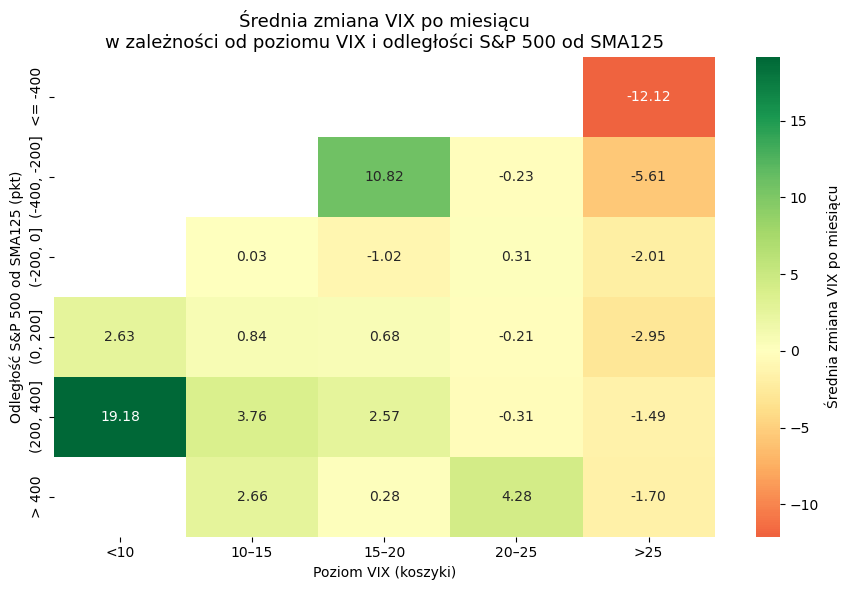

In [310]:
# Pivot — przekształcenie danych do formatu macierzy
heatmap_data = grouped_vix.pivot(
    index='Distance_bin', 
    columns='VIX_bin', 
    values='Avg_VIX_change_30d'
)

# Rysujemy heatmapę (zielony = wzrost VIX, czerwony = spadek)
plt.figure(figsize=(9, 6))
sns.heatmap(
    heatmap_data,
    annot=True,          # wyświetla wartości
    fmt=".2f",
    cmap="RdYlGn",       # zielony = wzrost, czerwony = spadek
    center=0,            # środek palety = 0
    cbar_kws={'label': 'Średnia zmiana VIX po miesiącu'}
)

plt.title(
    "Średnia zmiana VIX po miesiącu\n"
    "w zależności od poziomu VIX i odległości S&P 500 od SMA125",
    fontsize=13
)
plt.xlabel("Poziom VIX (koszyki)")
plt.ylabel("Odległość S&P 500 od SMA125 (pkt)")
plt.tight_layout()
plt.show()

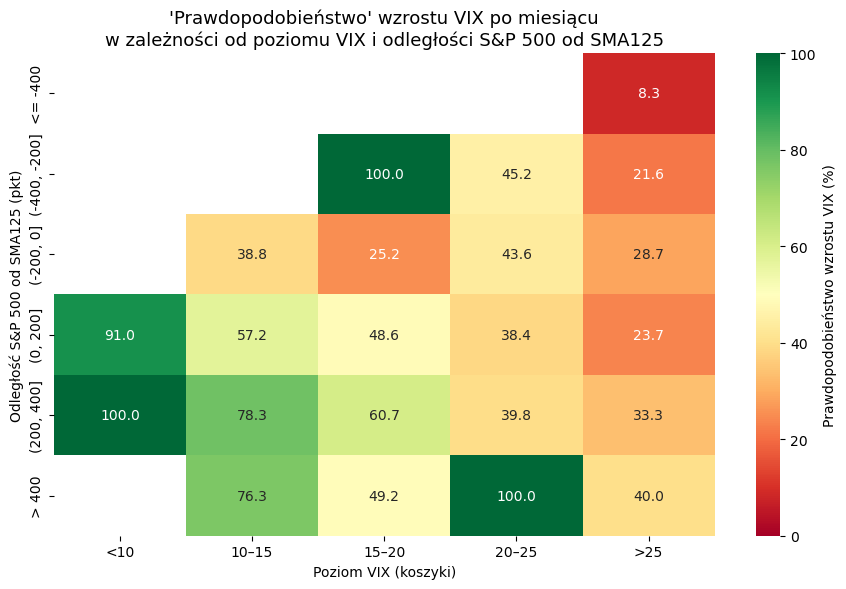

In [311]:
# Pivot — przygotowanie danych
heatmap_up = grouped_vix.pivot(
    index='Distance_bin', 
    columns='VIX_bin', 
    values='Up_pct'
)

# Rysunek
plt.figure(figsize=(9, 6))
sns.heatmap(
    heatmap_up,
    annot=True,          # pokazuje wartości procentowe
    fmt=".1f",           # jedno miejsce po przecinku
    cmap="RdYlGn",       # zielony = częsty wzrost VIX, czerwony = rzadki wzrost
    vmin=0, vmax=100,    # zakres 0–100%
    cbar_kws={'label': 'Prawdopodobieństwo wzrostu VIX (%)'}
)

plt.title(
    "'Prawdopodobieństwo' wzrostu VIX po miesiącu\n"
    "w zależności od poziomu VIX i odległości S&P 500 od SMA125",
    fontsize=13
)
plt.xlabel("Poziom VIX (koszyki)")
plt.ylabel("Odległość S&P 500 od SMA125 (pkt)")
plt.tight_layout()
plt.show()

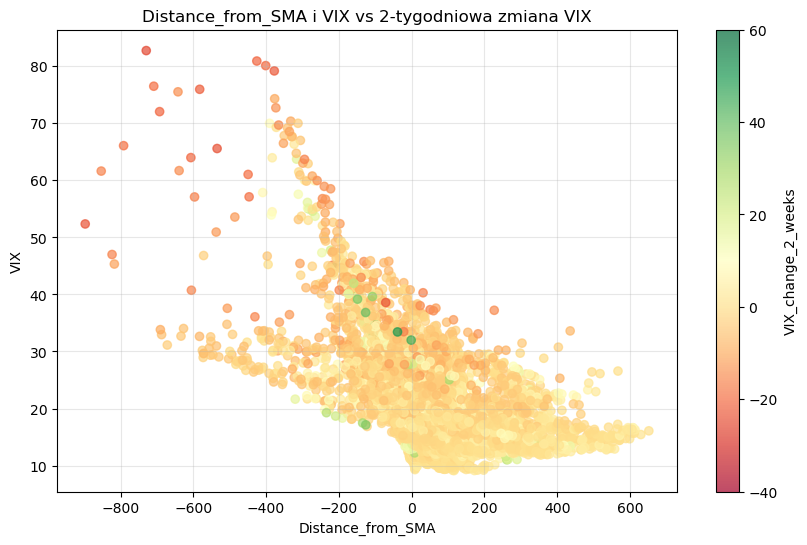

In [312]:
# Tworzymy kolumnę z 14-dniową zmianą VIX
df['VIX_change_14d'] = df['VIX_14_days_later'] - df['VIX_Close']

# Usuwamy brakujące wartości
df_plot = df.dropna(subset=['VIX_change_14d', 'VIX_Close', 'Distance_from_SMA'])

# Scatter plot z ustalonym zakresem kolorów
plt.figure(figsize=(10,6))
scatter = plt.scatter(
    df_plot['Distance_from_SMA'],
    df_plot['VIX_Close'],
    c=df_plot['VIX_change_14d'],   # kolor wg zmiany VIX po 14 dniach
    cmap='RdYlGn',
    alpha=0.7,
    vmin=-40,   # minimalna wartość koloru
    vmax=60     # maksymalna wartość koloru
)

plt.colorbar(scatter, label='VIX_change_2_weeks')
plt.xlabel("Distance_from_SMA")
plt.ylabel("VIX")
plt.title("Distance_from_SMA i VIX vs 2-tygodniowa zmiana VIX")
plt.grid(True, alpha=0.3)
plt.show()

In [313]:
# Obliczamy 14-dniową zmianę VIX
df['VIX_change_14d'] = df['VIX_14_days_later'] - df['VIX_Close']

# Definiujemy koszyki Distance_from_SMA
distance_bins = [-np.inf, -400, -200, 0, 200, 400, np.inf]
distance_labels = ["<= -400", "(-400, -200]", "(-200, 0]", "(0, 200]", "(200, 400]", "> 400"]

# Definiujemy koszyki VIX
vix_bins = [0, 10, 15, 20, 25, np.inf]
vix_labels = ["<10", "10–15", "15–20", "20–25", ">25"]

# Tworzymy kopię z potrzebnymi kolumnami
df_bins = df.dropna(subset=['VIX_Close', 'VIX_change_14d', 'Distance_from_SMA']).copy()

# Przypisujemy koszyki
df_bins['Distance_bin'] = pd.cut(df_bins['Distance_from_SMA'], bins=distance_bins, labels=distance_labels)
df_bins['VIX_bin'] = pd.cut(df_bins['VIX_Close'], bins=vix_bins, labels=vix_labels)

# Grupujemy dane po dwóch wymiarach
grouped_vix_14d = df_bins.groupby(['Distance_bin', 'VIX_bin']).agg(
    Total_obs=('VIX_change_14d', 'count'),
    Up_days=('VIX_change_14d', lambda x: (x > 0).sum()),      # wzrost VIX po 14 dniach
    Down_days=('VIX_change_14d', lambda x: (x < 0).sum()),    # spadek VIX po 14 dniach
    Up_pct=('VIX_change_14d', lambda x: (x > 0).mean() * 100),
    Down_pct=('VIX_change_14d', lambda x: (x < 0).mean() * 100),
    Avg_VIX_change_14d=('VIX_change_14d', 'mean'),
    Max_VIX_increase_14d=('VIX_change_14d', 'max'),
    Max_VIX_drop_14d=('VIX_change_14d', 'min')
).reset_index()

# Wyświetlamy wyniki
pd.set_option('display.max_rows', None)
print(grouped_vix_14d)

    Distance_bin VIX_bin  Total_obs  Up_days  Down_days      Up_pct  \
0        <= -400     <10          0      NaN        NaN         NaN   
1        <= -400   10–15          0      NaN        NaN         NaN   
2        <= -400   15–20          0      NaN        NaN         NaN   
3        <= -400   20–25          0      NaN        NaN         NaN   
4        <= -400     >25         72      6.0       66.0    8.333333   
5   (-400, -200]     <10          0      NaN        NaN         NaN   
6   (-400, -200]   10–15          0      NaN        NaN         NaN   
7   (-400, -200]   15–20          4      4.0        0.0  100.000000   
8   (-400, -200]   20–25         31     10.0       21.0   32.258065   
9   (-400, -200]     >25        171     53.0      118.0   30.994152   
10     (-200, 0]     <10          0      NaN        NaN         NaN   
11     (-200, 0]   10–15        178     83.0       93.0   46.629213   
12     (-200, 0]   15–20        440    135.0      305.0   30.681818   
13    

C:\Users\lukas\AppData\Local\Temp\ipykernel_7472\4292914209.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vix_14d = df_bins.groupby(['Distance_bin', 'VIX_bin']).agg(


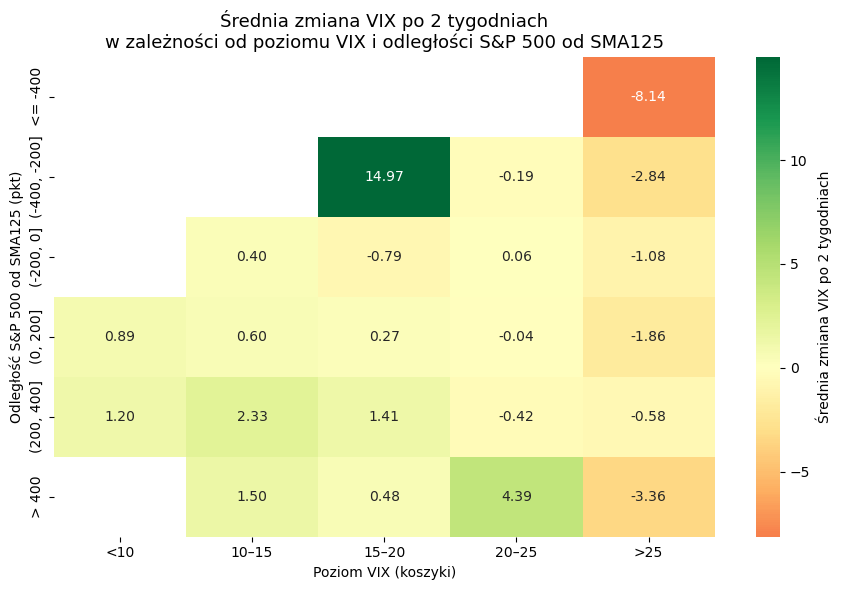

In [314]:
# Pivot — przekształcenie danych do formatu macierzy
heatmap_data_14d = grouped_vix_14d.pivot(
    index='Distance_bin',
    columns='VIX_bin',
    values='Avg_VIX_change_14d'
)

# Rysujemy heatmapę (zielony = wzrost VIX, czerwony = spadek)
plt.figure(figsize=(9, 6))
sns.heatmap(
    heatmap_data_14d,
    annot=True,          # wyświetla wartości
    fmt=".2f",
    cmap="RdYlGn",       # zielony = wzrost, czerwony = spadek
    center=0,            # środek palety = 0
    cbar_kws={'label': 'Średnia zmiana VIX po 2 tygodniach'}
)

plt.title(
    "Średnia zmiana VIX po 2 tygodniach\n"
    "w zależności od poziomu VIX i odległości S&P 500 od SMA125",
    fontsize=13
)
plt.xlabel("Poziom VIX (koszyki)")
plt.ylabel("Odległość S&P 500 od SMA125 (pkt)")
plt.tight_layout()
plt.show()

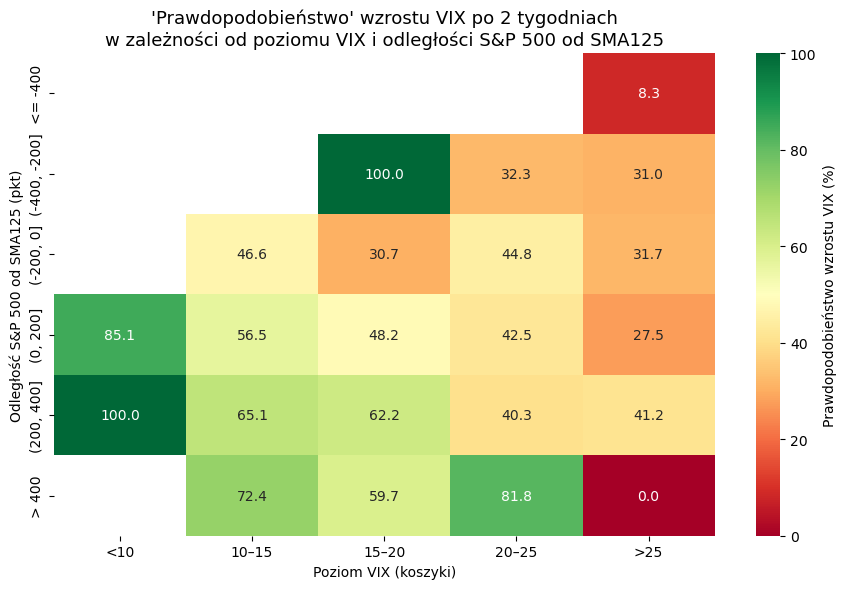

In [315]:
# Pivot — przygotowanie danych
heatmap_up_14d = grouped_vix_14d.pivot(
    index='Distance_bin',
    columns='VIX_bin',
    values='Up_pct'
)

# Rysunek
plt.figure(figsize=(9, 6))
sns.heatmap(
    heatmap_up_14d,
    annot=True,          # pokazuje wartości procentowe
    fmt=".1f",           # jedno miejsce po przecinku
    cmap="RdYlGn",       # zielony = częsty wzrost VIX, czerwony = rzadki wzrost
    vmin=0, vmax=100,    # zakres 0–100%
    cbar_kws={'label': 'Prawdopodobieństwo wzrostu VIX (%)'}
)

plt.title(
    "'Prawdopodobieństwo' wzrostu VIX po 2 tygodniach\n"
    "w zależności od poziomu VIX i odległości S&P 500 od SMA125",
    fontsize=13
)
plt.xlabel("Poziom VIX (koszyki)")
plt.ylabel("Odległość S&P 500 od SMA125 (pkt)")
plt.tight_layout()
plt.show()

In [316]:
df['VIX_Change_next_day'] = df['VIX_Close'].shift(-1) - df['VIX_Close']

In [317]:
mask = df['VIX_Change_next_day'] >= 0.05 * df['VIX_Close']

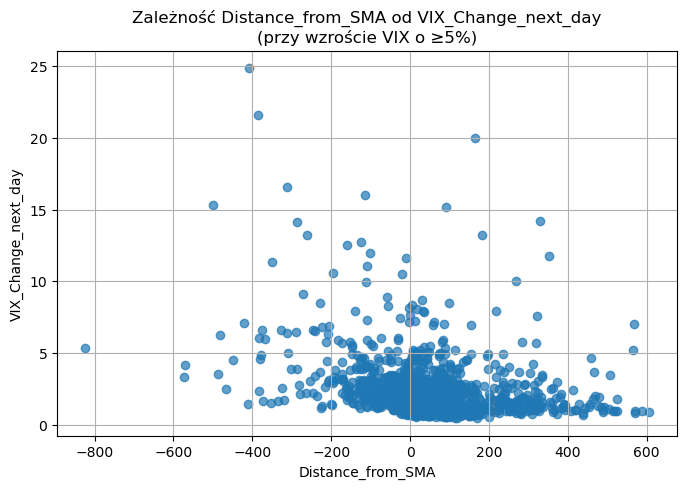

In [318]:
# Filtrowanie danych
filtered_df = df[mask]

plt.figure(figsize=(8,5))
plt.scatter(filtered_df['Distance_from_SMA'], filtered_df['VIX_Change_next_day'], alpha=0.7)
plt.title('Zależność Distance_from_SMA od VIX_Change_next_day\n(przy wzroście VIX o ≥5%)')
plt.xlabel('Distance_from_SMA')
plt.ylabel('VIX_Change_next_day')
plt.grid(True)
plt.show()

In [319]:
df['VIX_Change_pct_next_day'] = (df['VIX_Close'].shift(-1) - df['VIX_Close']) / df['VIX_Close']

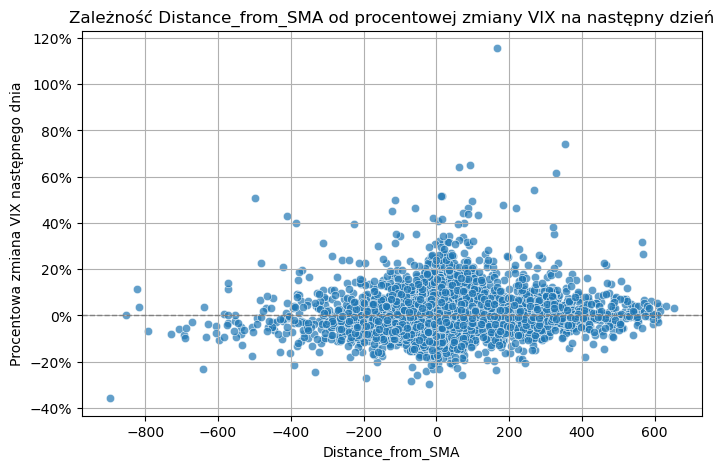

In [320]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    data=df,
    x='Distance_from_SMA',
    y='VIX_Change_pct_next_day',
    alpha=0.7
)

plt.title('Zależność Distance_from_SMA od procentowej zmiany VIX na następny dzień')
plt.xlabel('Distance_from_SMA')
plt.ylabel('Procentowa zmiana VIX następnego dnia')

plt.axhline(0, color='gray', linestyle='--', linewidth=1)  # linia 0%
plt.grid(True)

# Formatowanie osi Y w procentach
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))

plt.show()

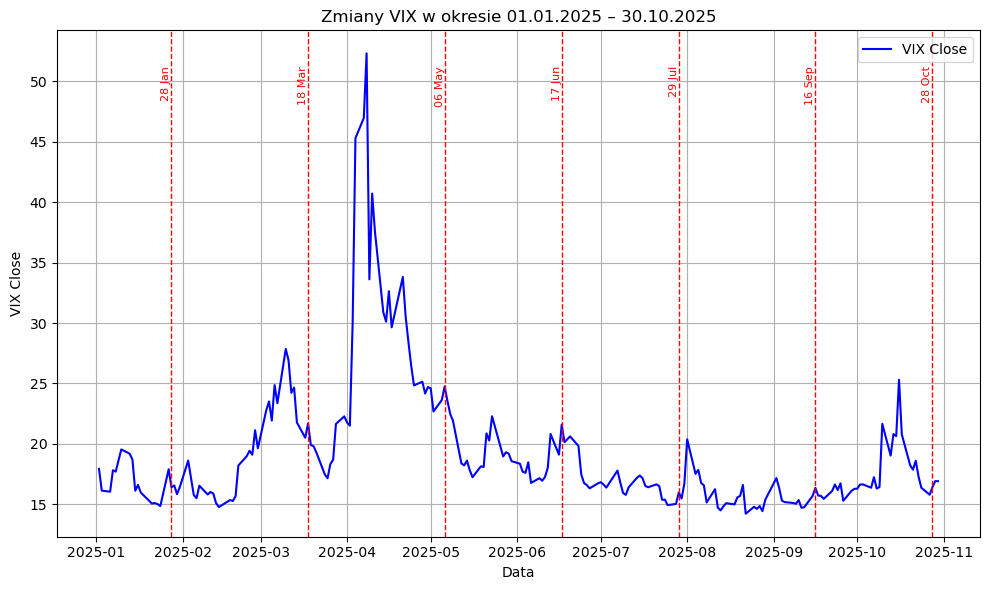

In [321]:
# VIX a posiedzenie FED
# Zakładamy, że kolumna 'Date' jest typu datetime:
df['Date'] = pd.to_datetime(df['Date'])

# Filtrujemy dane do zakresu 2025-01-01 – 2025-10-30
mask = (df['Date'] >= '2025-01-01') & (df['Date'] <= '2025-10-30')
df_period = df.loc[mask]

# Daty posiedzeń FOMC
fomc_dates = [
    '2025-01-28',
    '2025-03-18',
    '2025-05-06',
    '2025-06-17',
    '2025-07-29',
    '2025-09-16',
    '2025-10-28'
]
fomc_dates = pd.to_datetime(fomc_dates)

# Wykres
plt.figure(figsize=(10,6))
plt.plot(df_period['Date'], df_period['VIX_Close'], label='VIX Close', color='blue')
plt.title('Zmiany VIX w okresie 01.01.2025 – 30.10.2025')
plt.xlabel('Data')
plt.ylabel('VIX Close')
plt.grid(True)

# Dodajemy pionowe linie FOMC
for date in fomc_dates:
    plt.axvline(x=date, color='red', linestyle='--', linewidth=1)
    # podpisy:
    plt.text(date, df_period['VIX_Close'].max()*0.98,  # pozycja tekstu lekko poniżej max
             date.strftime('%d %b'), rotation=90, color='red',
             ha='right', va='top', fontsize=8)

plt.legend()
plt.tight_layout()
plt.show()